# Grid search with nested CV

In [14]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score,
                                     KFold, StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC
from src.suggnet.pipeline import FeatureExtractor

In [2]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [3]:
# create a list of combination of kinds and frequency bands.
kinds = ['correlation source', 'power source', 'power sensor',
        'plv source', 'correlation sensor', 'plv sensor']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]

In [10]:
cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}

# Choose cross-validation techniques for the inner and outer loops,
outer_cv = GroupShuffleSplit(n_splits=20, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)

models
for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # 2. PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', 'passthrough'),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # 3. grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
        'select': [SelectFromModel(SVC(max_iter=1000000, kernel='linear')), 'passthrough'],
        'clf__C': [0.1, 0.5, 1, 5, 10, 50, 100],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/nested_grid_results.csv')

  0%|          | 0/7 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>correlation sensor (beta)<<<<<<<<<<<<<<<<<<


 14%|█▍        | 1/7 [10:07<1:00:43, 607.17s/it]

>>>>>>>>>>>>>>>>>correlation sensor (gamma)<<<<<<<<<<<<<<<<<<


 29%|██▊       | 2/7 [20:14<50:37, 607.45s/it]  

>>>>>>>>>>>>>>>>>plv sensor (delta)<<<<<<<<<<<<<<<<<<


 43%|████▎     | 3/7 [29:10<38:18, 574.50s/it]

>>>>>>>>>>>>>>>>>plv sensor (theta)<<<<<<<<<<<<<<<<<<


 57%|█████▋    | 4/7 [38:10<28:02, 560.84s/it]

>>>>>>>>>>>>>>>>>plv sensor (alpha)<<<<<<<<<<<<<<<<<<


 71%|███████▏  | 5/7 [47:06<18:23, 551.89s/it]

>>>>>>>>>>>>>>>>>plv sensor (beta)<<<<<<<<<<<<<<<<<<


 86%|████████▌ | 6/7 [56:01<09:06, 546.30s/it]

>>>>>>>>>>>>>>>>>plv sensor (gamma)<<<<<<<<<<<<<<<<<<


100%|██████████| 7/7 [1:05:00<00:00, 557.26s/it]


## Classifications with nestet CV and without hyperparameter tuning

In [5]:
models = [('power sensor', 'beta'), ('power sensor', 'gamma')]

In [ ]:
cv_scores = []
best_estimators = []
importances = []
models_test_accuraies = {}

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=50, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)


for m in tqdm(models, total=len(models)):

    kind = m[0]
    frequency_band = m[1]
    model_name = f'{kind} ({frequency_band})'
    
    print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
    
    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        test_accuraies.append((y[test] == y_pred).mean())
    
    models_test_accuraies[model_name] = test_accuraies

# pd.DataFrame(models_test_accuraies).to_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv')

### Visulization

In [15]:
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv', index_col=0)

# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()

# chance score
CHANCE_CV = GroupShuffleSplit(n_splits=50, test_size=0.2)
def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    pipe = Pipeline([
        ('extract', FeatureExtractor(kind='power sensor', frequency_band='gamma')),
        ('zerovar', VarianceThreshold(threshold=0.0)),
        ('scale', StandardScaler()),
        ('clf', DummyClassifier(strategy='most_frequent'))
    ])
    chance_scores = cross_val_score(pipe, X, y, groups=groups, cv=CHANCE_CV, scoring='accuracy', n_jobs=-1)
    return chance_scores

chance_scores = {}
for model_name in grid_results['variable'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[model_name] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

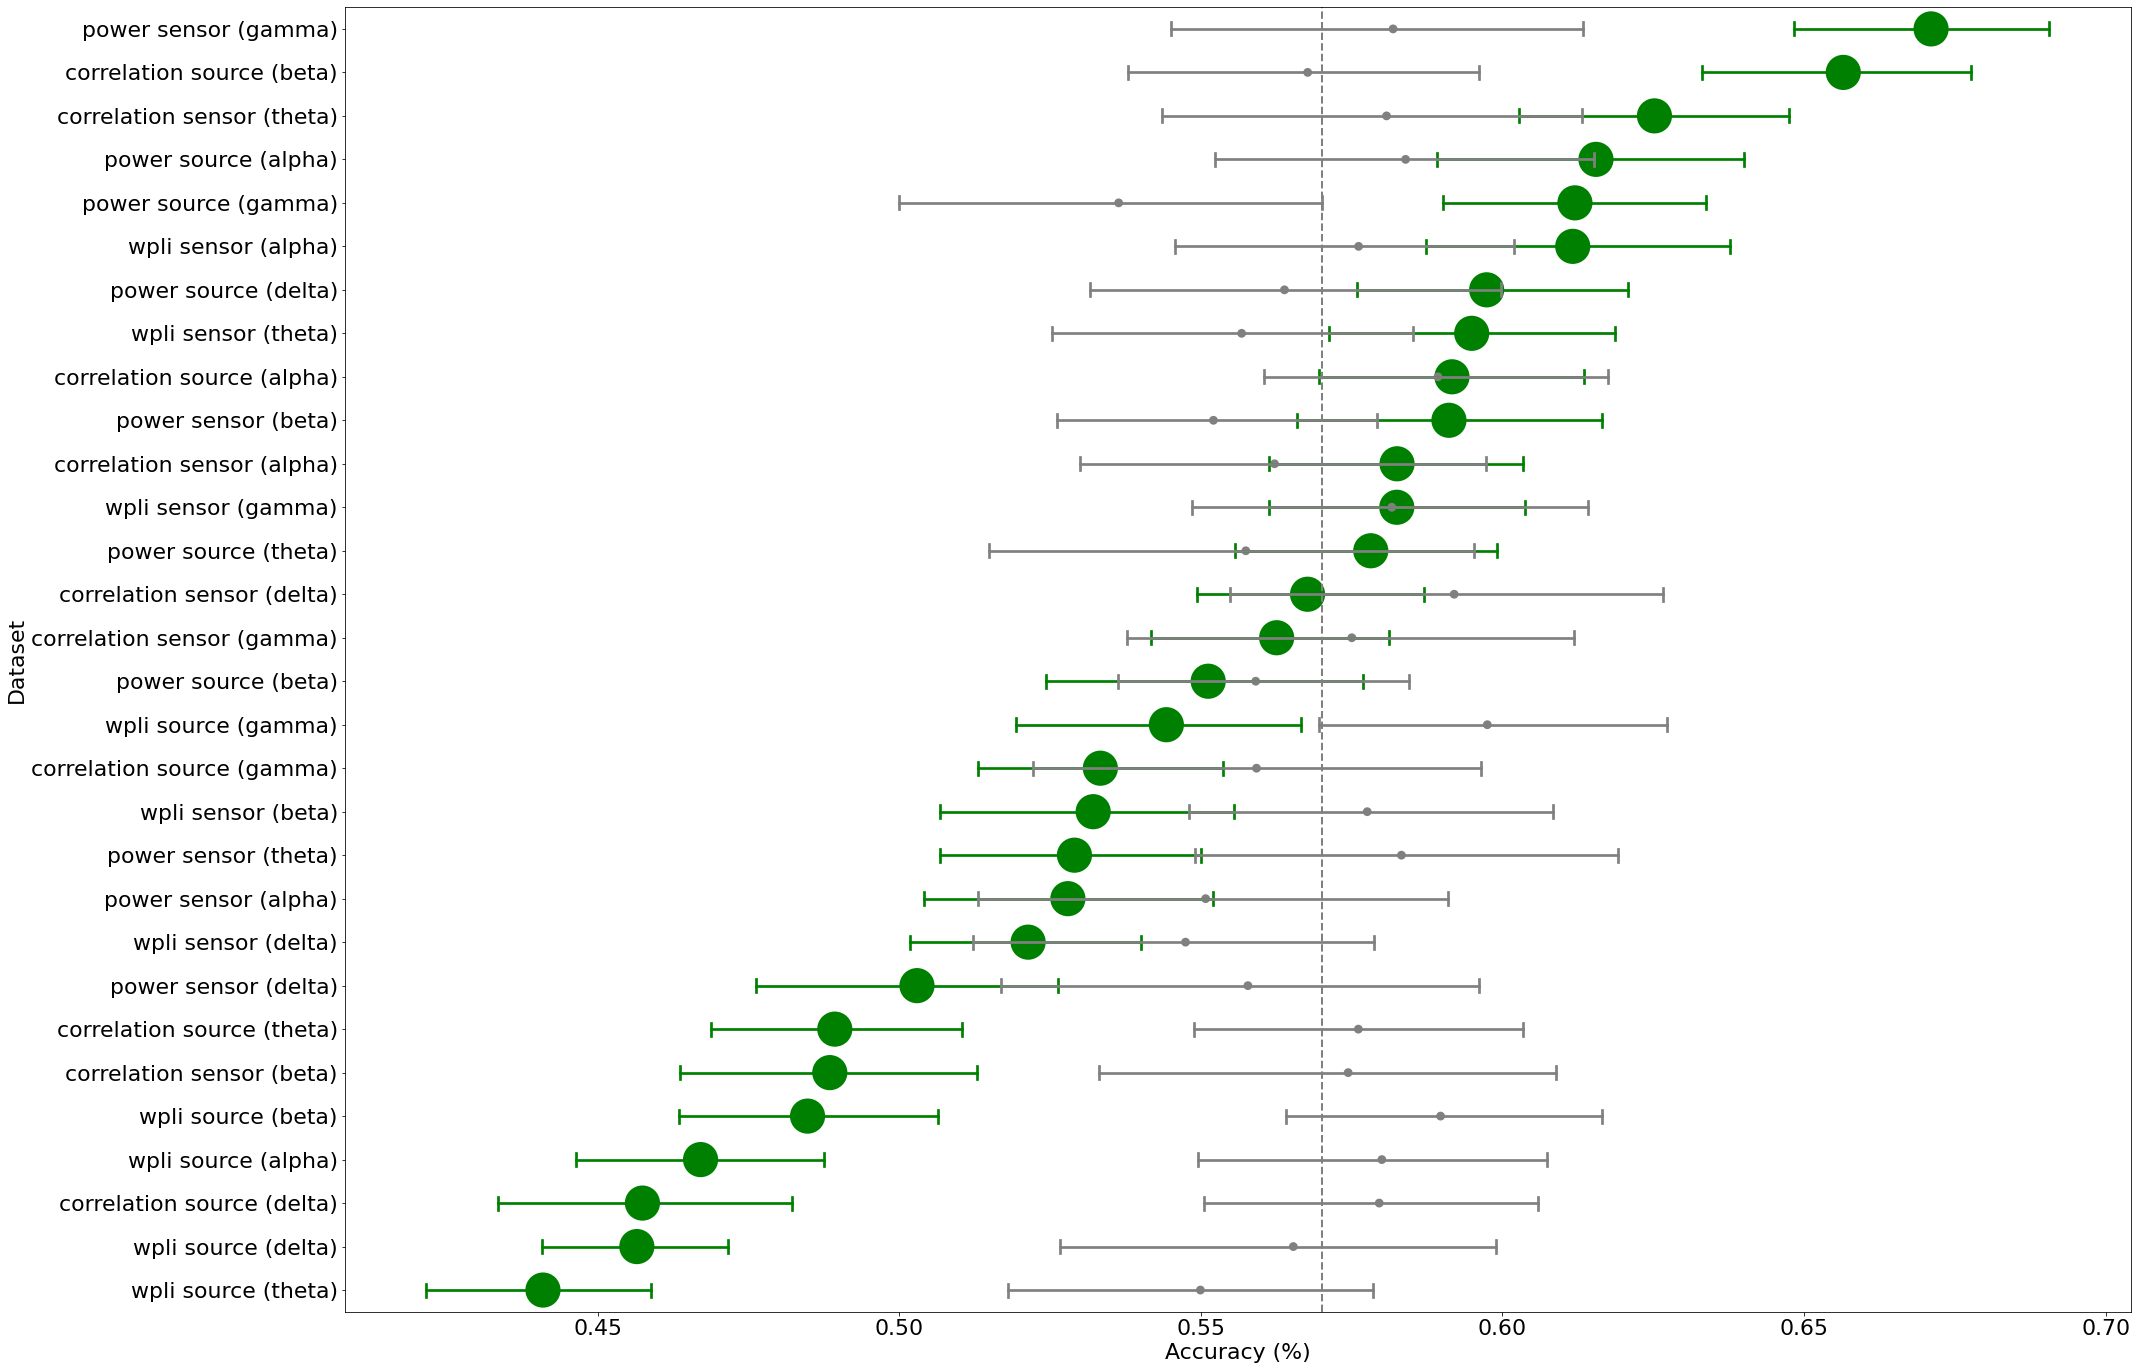

In [73]:
order = grid_results.groupby('variable')['value'].mean().sort_values(ascending=False).index.values

_, ax = plt.subplots(1, 1, figsize=(32, 24))

# plot observed
sns.pointplot(data=grid_results, x='value', y='variable', order=order, orient='h',
              color='green', scale=4, capsize=0.3, join=False, label='Accuracy', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

# plot chance
sns.pointplot(data=chance_scores, x='test_score', y='label', order=order, orient='h',
              color='gray', scale=1, capsize=0.3, join=False, label='Chance', dodge=True,
              ax=ax, errorbar=('ci', 99)
              )

plt.axvline(0.57, color='grey', linestyle='--', linewidth=2)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel('Accuracy (%)', fontsize=22)
plt.ylabel('Dataset', fontsize=22)
# plt.title('SVM Validation Accuracy (100x 5-fold CV)')

# plt.legend(loc="upper left")

plt.show()